In [1]:
import math as m
import cv2 
import numpy as np
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt

class Fast_LBP():
	def __init__(self, radius=1, neighbors=8):
		self._radius = radius
		self._neighbors = neighbors
	@property
	def radius(self):
		return self._radius
	@property
	def neighbors(self):
		return self._neighbors		
	def Compute_LBP(self,Image):
		#Determine the dimensions of the input image.
		ysize, xsize = Image.shape
		# define circle of symetrical neighbor points
		angles_array = 2*np.pi/self._neighbors
		alpha = np.arange(0,2*np.pi,angles_array)
		# Determine the sample points on circle with radius R
		s_points = np.array([-np.sin(alpha), np.cos(alpha)]).transpose()
		s_points *= self._radius
		# s_points is a 2d array with 2 columns (y,x) coordinates for each cicle neighbor point		
		# Determine the boundaries of s_points wich gives us 2 points of coordinates
		# gp1(min_x,min_y) and gp2(max_x,max_y), the coordinate of the outer block 
		# that contains the circle points
		min_y=min(s_points[:,0])
		max_y=max(s_points[:,0])
		min_x=min(s_points[:,1])
		max_x=max(s_points[:,1])
		# Block size, each LBP code is computed within a block of size bsizey*bsizex
		# so if radius = 1 then block size equal to 3*3
		bsizey = np.ceil(max(max_y,0)) - np.floor(min(min_y,0)) + 1
		bsizex = np.ceil(max(max_x,0)) - np.floor(min(min_x,0)) + 1
		# Coordinates of origin (0,0) in the block
		origy =  int(0 - np.floor(min(min_y,0)))
		origx =  int(0 - np.floor(min(min_x,0)))
		#Minimum allowed size for the input image depends on the radius of the used LBP operator.
		if xsize < bsizex or ysize < bsizey :
			raise Exception('Too small input image. Should be at least (2*radius+1) x (2*radius+1)')
		# Calculate dx and dy: output image size
		# for exemple, if block size is 3*3 then we need to substract the first row and the last row which is 2 rows
		# so we need to substract 2, same analogy applied to columns
		dx = int(xsize - bsizex + 1)
		dy = int(ysize - bsizey + 1)
		# Fill the center pixel matrix C.
		C = Image[origy:origy+dy,origx:origx+dx]
		# Initialize the result matrix with zeros.
		result = np.zeros((dy,dx), dtype=np.float32)
		for i in range(s_points.shape[0]):
			# Get coordinate in the block:
			p = s_points[i][:]
			y,x = p + (origy, origx)
			# Calculate floors, ceils and rounds for the x and ysize
			fx = int(np.floor(x))
			fy = int(np.floor(y))
			cx = int(np.ceil(x))
			cy = int(np.ceil(y))
			rx = int(np.round(x))
			ry = int(np.round(y))
			D = [[]]
			if np.abs(x - rx) < 1e-6 and np.abs(y - ry) < 1e-6:
			#Interpolation is not needed, use original datatypes
				N = Image[ry:ry+dy,rx:rx+dx]
				D = (N >= C).astype(np.uint8)
			else:
				# interpolation is needed
				# compute the fractional part.
				ty = y - fy
				tx = x - fx
				# compute the interpolation weight.
				w1 = (1 - tx) * (1 - ty)
				w2 = tx * (1 - ty)
				w3 = (1 - tx) * ty
				w4 = tx * ty
				# compute interpolated image:
				N = w1*Image[fy:fy+dy,fx:fx+dx]
				N = np.add(N, w2*Image[fy:fy+dy,cx:cx+dx], casting="unsafe")
				N = np.add(N, w3*Image[cy:cy+dy,fx:fx+dx], casting="unsafe")
				N = np.add(N, w4*Image[cy:cy+dy,cx:cx+dx], casting="unsafe")
				D = (N >= C).astype(np.uint8)
			#Update the result matrix.
			v = 2**i
			result += D*v
		return result.astype(np.uint8)

In [2]:
class features_extraction():
    def __init__(self, lbp, grid_size = (8,8)):
        self._lbp = lbp
        self._grid_size = grid_size
    def lbp_histograms(self, image):
        # compute the lbp of the image
        LBP = self._lbp.Compute_LBP(image)
        print(LBP)
        # divide the lbp imgae into small regions
        LBP_height, LBP_width = LBP.shape
        Grid_rows, Grid_cols = self._grid_size
        row_number = int(LBP_height/Grid_rows)
        col_number = int(LBP_width/Grid_cols)
        features = []
        for row in range(0,Grid_rows):
            cv2.line(image, (int(row*row_number),0), (int(row*row_number),255), (0, 0, 0) , 2) 
            cv2.line(image, (0,int(row*row_number)), (255,int(row*row_number)), (0, 0, 0) , 2)
            for col in range(0,Grid_cols):
                Chunk_LBP = LBP[row*row_number:(row+1)*row_number,col*col_number:(col+1)*col_number]
                #compute the histogram for each region
                (Histogram, bins) = np.histogram(Chunk_LBP, bins=2**8,
                 range=(0, 2**8))
                width = bins[1] - bins[0]
                center = (bins[:-1] + bins[1:]) / 2
                axs[row][col].bar(center, Histogram, align='center', width=width)
                np.append(features, Histogram, 0)
                print(row)
        return np.asarray(features)

[[155 155 156 ... 149 149 148]
 [154 155 156 ... 150 149 148]
 [154 154 154 ... 150 149 149]
 ...
 [164 164 164 ...  33  33  33]
 [165 153 135 ...  33  33  33]
 [105  78  41 ...  33  33  33]]
[[  7   7  31 ... 253 112 124]
 [255 127  14 ... 112 252 253]
 [127  30 127 ... 253 240 249]
 ...
 [252 255 227 ... 255 255 255]
 [ 17  17  16 ... 255 255 255]
 [ 30  30  30 ... 255 255 255]]
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7


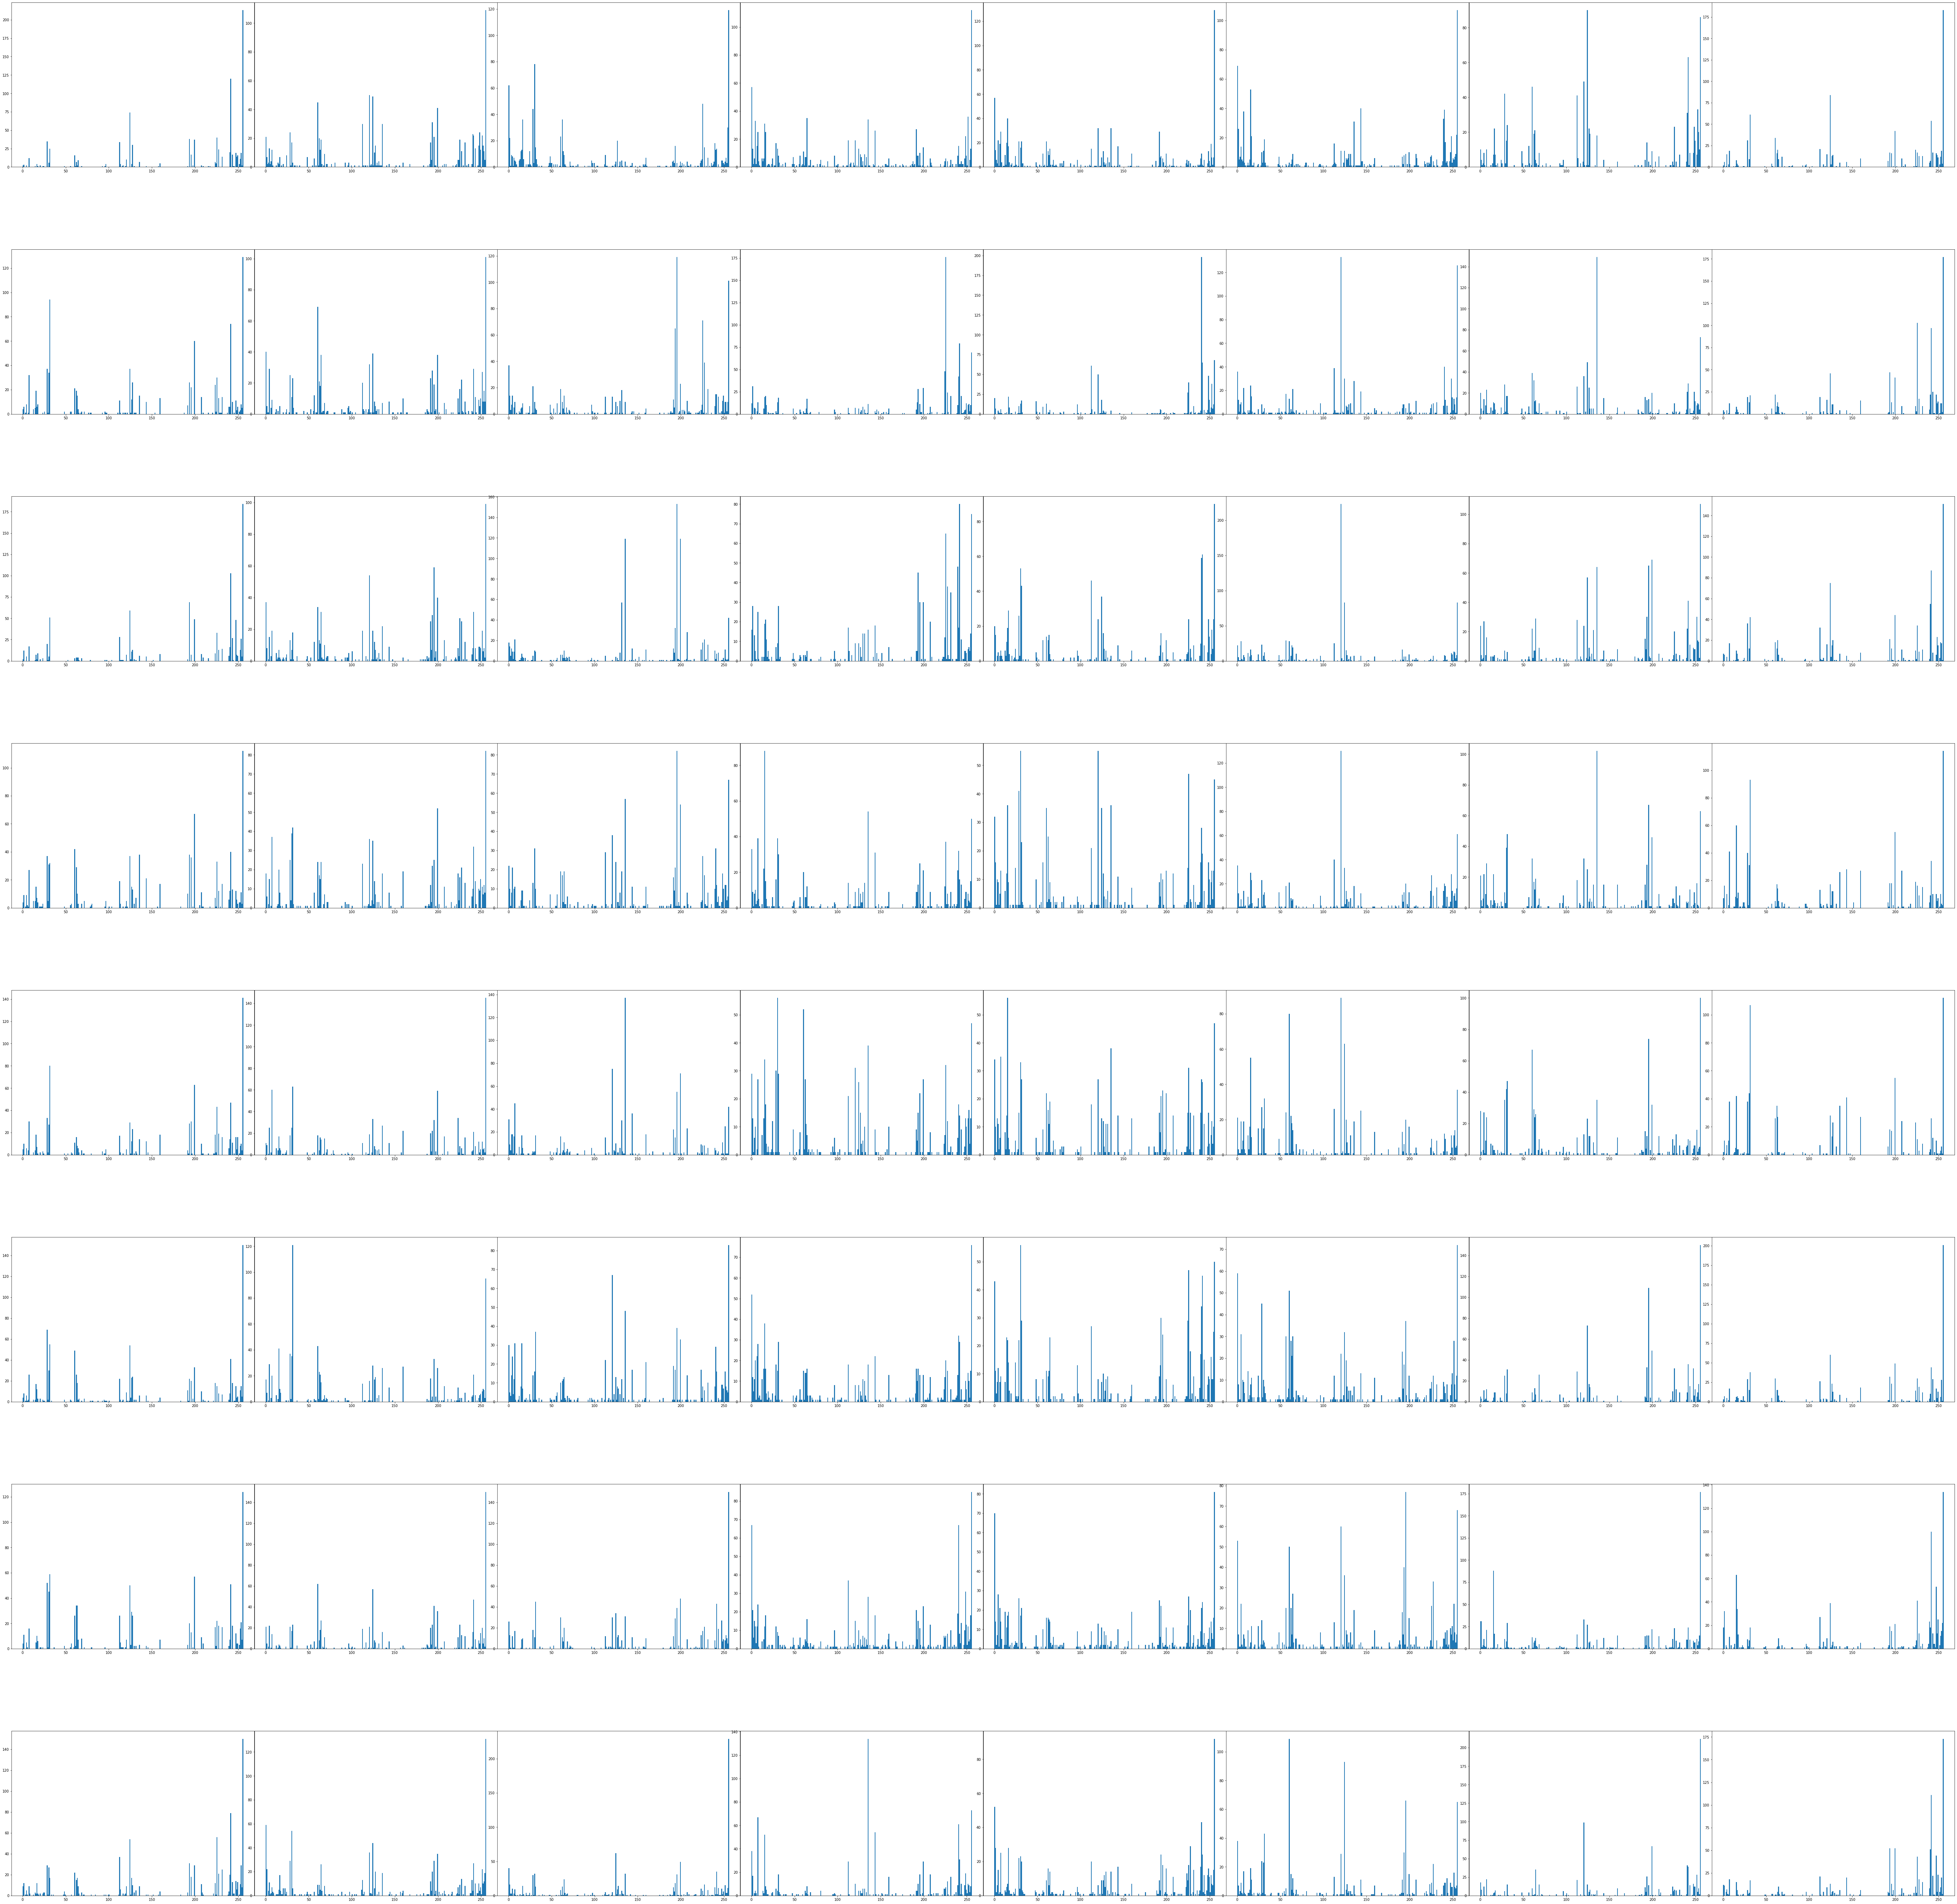

In [3]:
img = np.array(cv2.imread("images/img3.jpg",cv2.IMREAD_GRAYSCALE), 'uint8')
print(img)
fig, axs = plt.subplots(8,8, figsize=(100,100), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

lbp = Fast_LBP(1,8)
features_extraction = features_extraction(lbp)
features_extraction.lbp_histograms(img)

plt.show()
cv2.imshow('image', img)
if cv2.waitKey(0) & 0xFF == ord("q"):
    pass    
